In [20]:
import numpy as np
from matplotlib import pyplot as plt 
import cv2

## Lab 3: Image clustering and superpixels

In this lab we are going to explore image clustering and superpixels segmentation. You will be required to complete the following tasks:

1. Implement k-means clustering to assign each pixel of an image to one of K distinct clusters, using colour similarity to determine assignment.
2. Modify your k-means clustering to find superpixels by assigning each pixel of the image to one of K distinct clusters, using both colour and location similarity to determine assignment.
3. Use superpixels to propose regions of interest in the image (we will learn about neural networks that use this information in week 11). 
4. Write a brief report (max 600 words) discussing explaining your implementation and results. Explain your reasoning by referencing the intermediate result figures you generated. 

You may use numpy and matplotlib and opencv for image loading.

### Academic integrity

Every lab submission will be screened for any collusion and/or plagiarism. Breaches of academic integrity will be investigated thoroughly and may result in a zero for the assessment along with interviews with the plagiarism officers at Monash University.

### Late submissions

The default late submission university penalty will apply.

### Lab Instructions and the Use of Generative AI

You may not use any built-in opencv functions for this lab, other than those used for loading/ saving an image, extracting and matching keypoints, and
computing homographies.
* You may use NumPy for array handling, and vectorizing your code (reducing
the number of for-loops) is encouraged.
* You should use Matplotlib to display images and any intermediate results.
* You may use generative AI.

### Grading
Each lab is worth 8%, and there are a number of sections and tasks with their own weighting. A task is only considered complete if you can demonstrate a working program and show an understanding of the underlying concepts. Note that later tasks should reuse code from earlier tasks.

Masks will be provided based on the correctness of the code, the quality of your results, comments indicating you understand your work, and a discussion of tasks provided at the end of the notebook. 

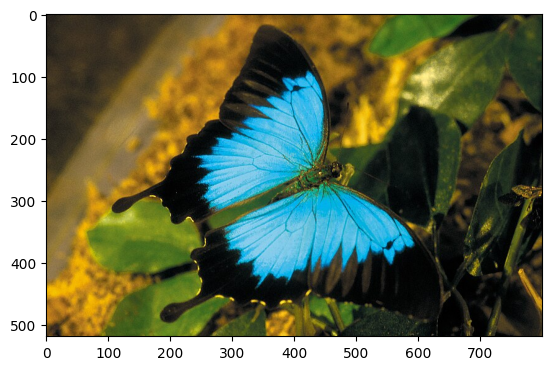

In [21]:
# Load and display image for testing
im_grb = cv2.imread('CSIRO_ScienceImage_3831_Ulysses_Butterfly.jpg')/255.0
plt.imshow(im_grb[:,:,[2,1,0]])
plt.show()
# Convert to rgb
im = im_grb[:,:,[2,1,0]]


### Task 1: Implement K-means from first principles: colour similarity

Fill in the function below to implement the following steps. Your function should accept an image, a variable storing the number of iterations to repeat k-means for, the number of clusters K.
1. Flatten the image into an Nx3 vector of pixels (num pixels x r,g,b colour of pixel)
2. Select K random colour centroids
3. Repeat for n iterations:
   1. Assign each pixel in the vector to a cluster and store the index corresponding to this in a numpy array
   2. Update the centroid locations using the new cluster assignments
   3. Save the total loss at each iteration
4. Convert the cluster index array back into a 2D array the same size as the image, where each pixel contains the corresponding cluster index
5. Create a new quantised image, where each pixel is coloured according to the centroid corresponding to a given cluster index.
6. Return the loss, cluster index image and quantised image
7. Test your function on the sample image provided, and select an appropriate number of iterations 
8. Display the results for a number of choices of K. Use the returned losses to select an appropriate value for K 

In [22]:
def kmeans(im, iters=10, K=3, plot=False):
    # Kmeans is stochastic, so we will fix the seed of the random number generator to ensure each iteration starts with the same centroid initialisation
    seed = 42
    np.random.seed(seed)
    # Convert image into an Nx3 vector of pixels 
    h, w, c = im.shape
    pixels = im.reshape(-1, 3).astype(np.float64)
    N= pixels.shape[0]
    # Create some random labels to assign to each pixel
    pix_labels = np.random.randint(0, K, im.shape[0]*im.shape[1])
    centroids = np.zeros((K, 3))
    for k in range(K):
        cluster_points = pixels[pix_labels == k]
        if len(cluster_points) == 0:
            centroids[k] = pixels[np.random.randint(0, N)]
        else:
            centroids[k] = cluster_points.mean(axis=0)
    for j in range(1,iters+1):
        # Assign pixels to clusters
        # i.e. assign each pixel to the cluster with the closest centroid
        dists = np.linalg.norm(pixels[:, None, :] - centroids[None, :, :], axis=2)
        cluster_indices = np.argmin(dists, axis=1)
        # Update centroid locations using new cluster assignments
        for k in range(K):
            cluster_pixels = pixels[cluster_indices == k]
            # I later ran into runtime errors when the cluster was empty, so I added this check
            if len(cluster_pixels)==0:
                centroids[k] = pixels[np.random.randint(0, pixels.shape[0])]
            else:
                centroids[k] = cluster_pixels.mean(axis=0)
            
        # Store the current loss
        # Loss = SSD to the centroids
        loss = np.sum((pixels - centroids[cluster_indices]) ** 2)

        
        # Convert cluster indices to an image
        cluster_idx_image = cluster_indices.reshape(h, w)
    
        # Create a quantised image using the clustering
        quantised_pixels = centroids[cluster_indices]
        quantised_image = quantised_pixels.reshape(h, w, c)

        
        # You may want to visualise the current progress of kmeans for debugging purposes
        if plot:
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.title(f'Cluster index image, iteration {j}')
            plt.imshow(cluster_idx_image, cmap='tab20') # Using a colormap to show the clusters
            plt.subplot(1,2,2)
            plt.imshow(quantised_image)
            plt.title(f'Quantised image, iteration {j}')
            plt.show()
        

    return loss, cluster_idx_image, quantised_image 


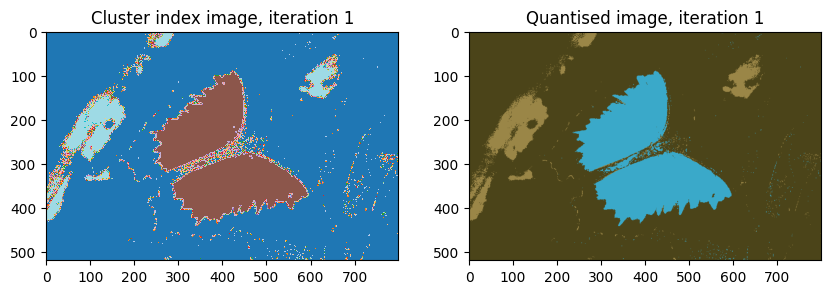

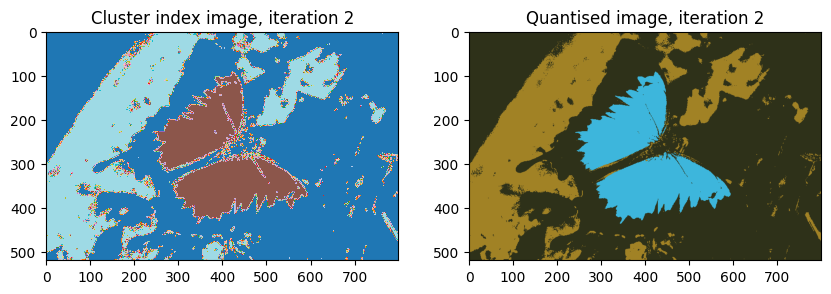

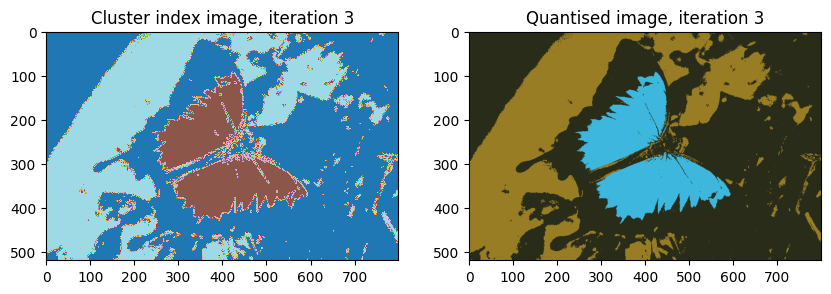

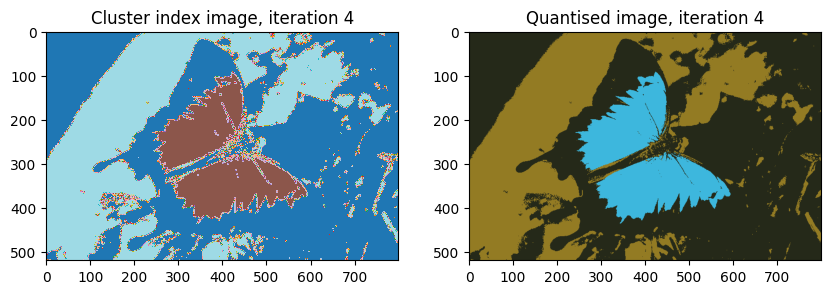

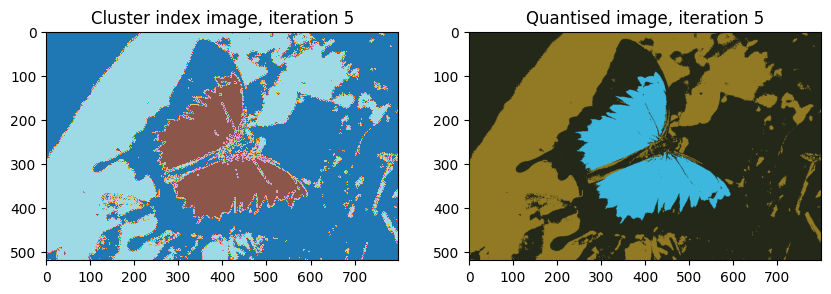

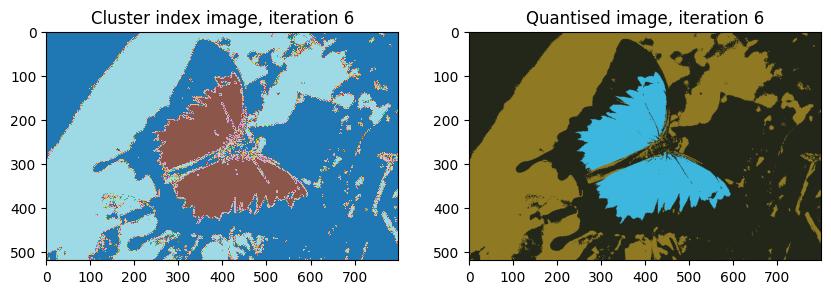

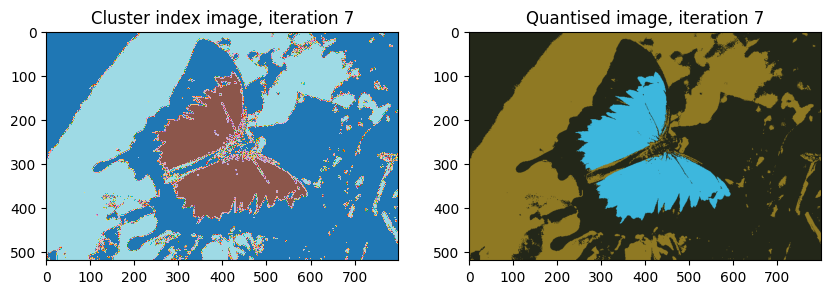

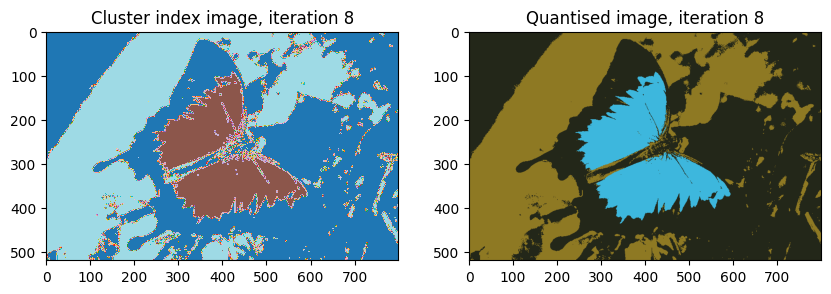

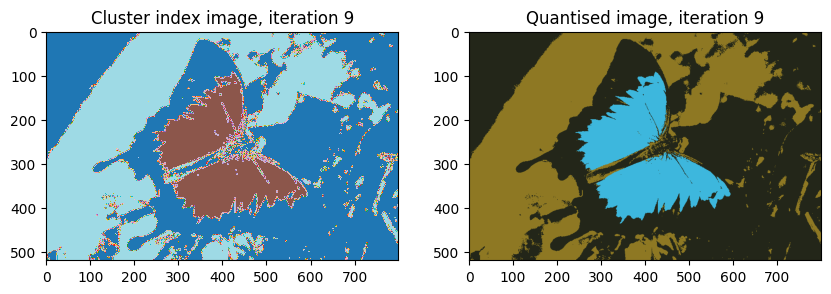

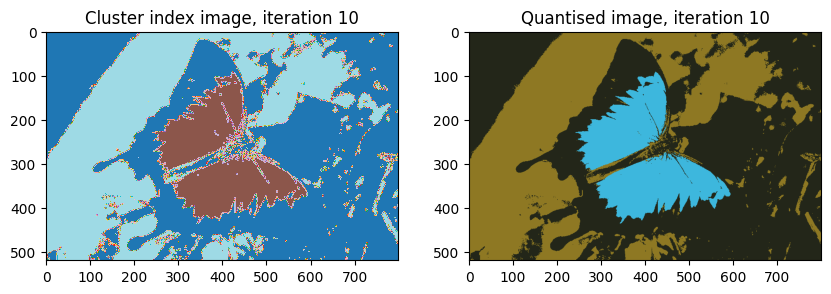

In [23]:
# Test your function using the image provided
loss, cluster_img, quantised_image = kmeans(im, iters=10, K=3, plot=True)



#### Iteration Testing:

Final loss for 1 iterations: 37743.23


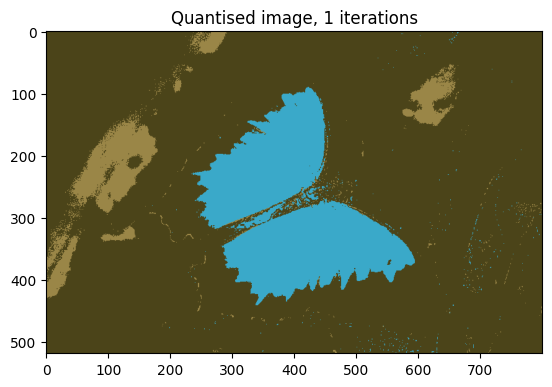

Final loss for 2 iterations: 15919.60


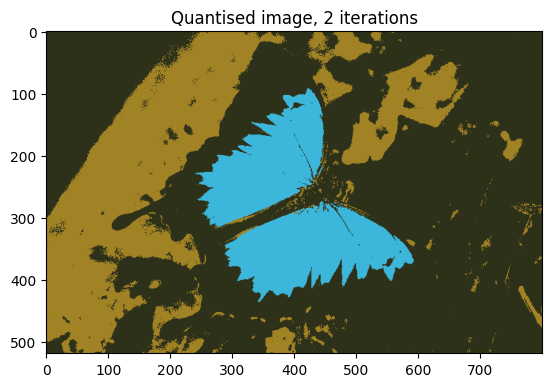

Final loss for 5 iterations: 13802.21


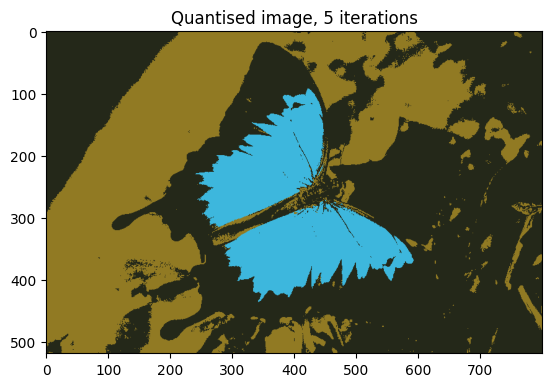

Final loss for 7 iterations: 13773.71


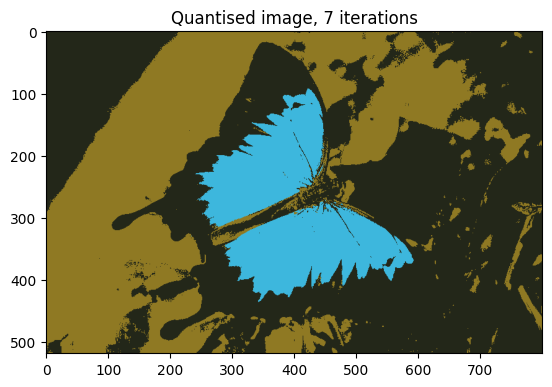

Final loss for 10 iterations: 13771.49


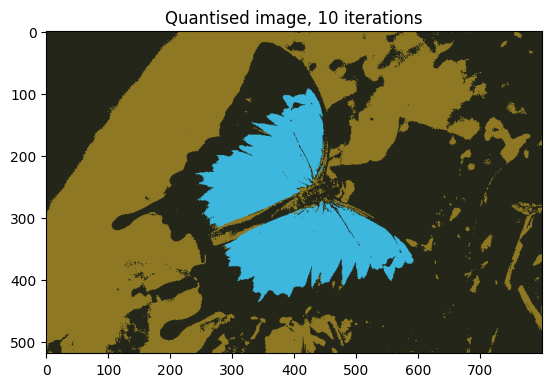

Final loss for 40 iterations: 13771.48


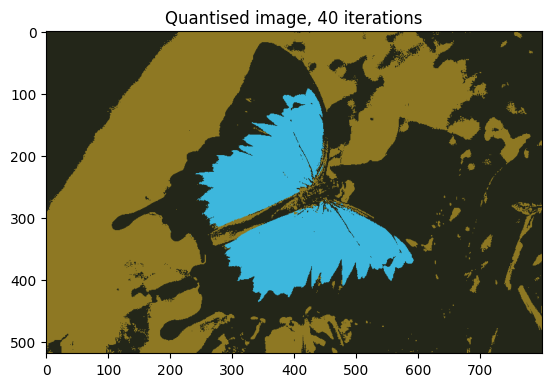

Final loss for 100 iterations: 13771.48


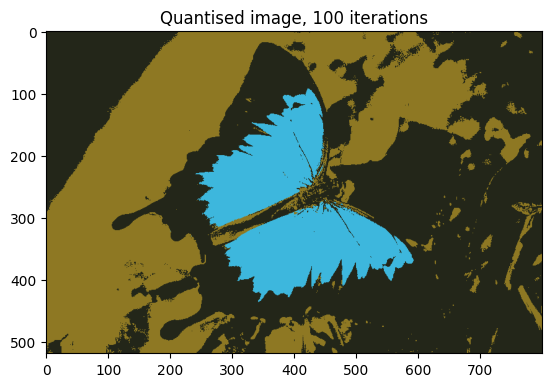

In [24]:
# Testing different numbers of iterations
iters = [1,2,5,7,10,40,100]
for i in iters:
    loss, cluster_img, quantised_image = kmeans(im, iters=i, K=3, plot=False)
    print(f'Final loss for {i} iterations: {loss:.2f}')
    plt.imshow(quantised_image)
    plt.title(f'Quantised image, {i} iterations')
    plt.show()

- After more than 10 iterations, loss stabilises. The calculations for 10+ iterations are also considerably more lengthy, so approx. 10 iterations is the optimal value.

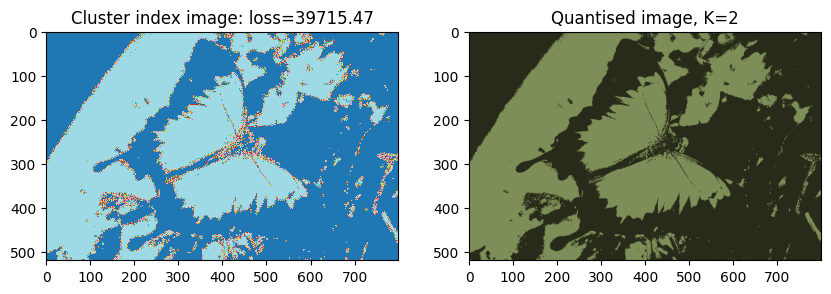

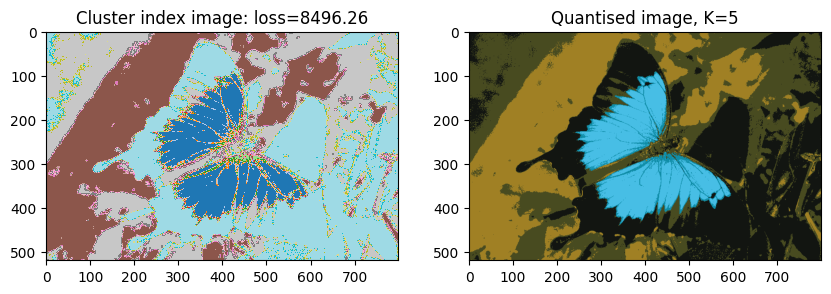

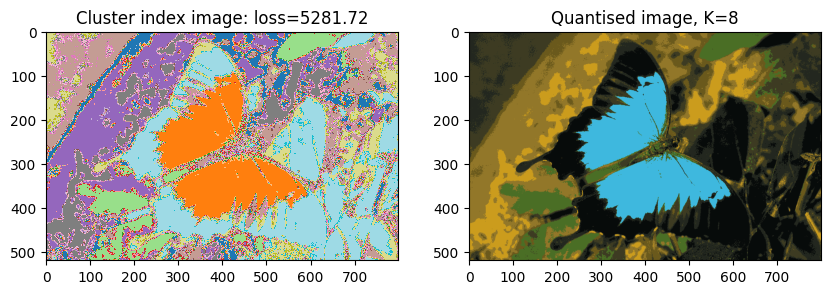

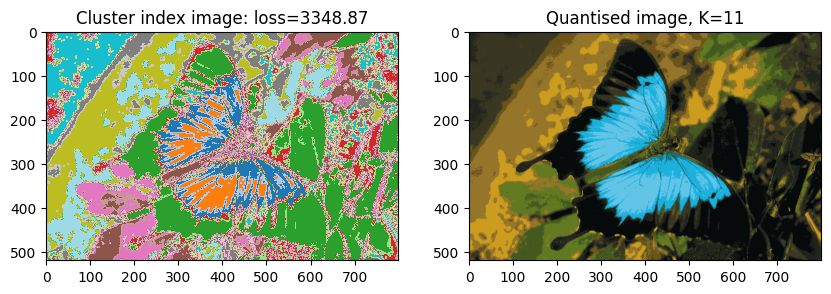

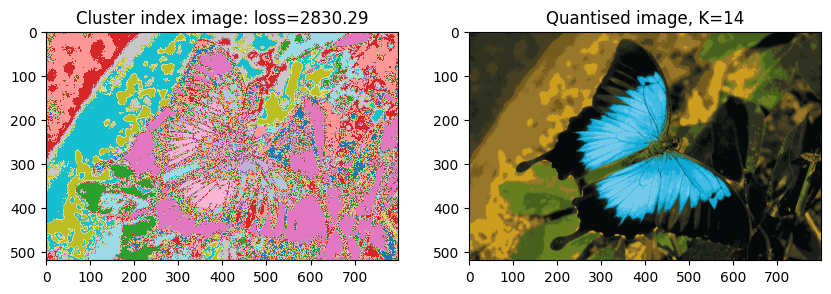

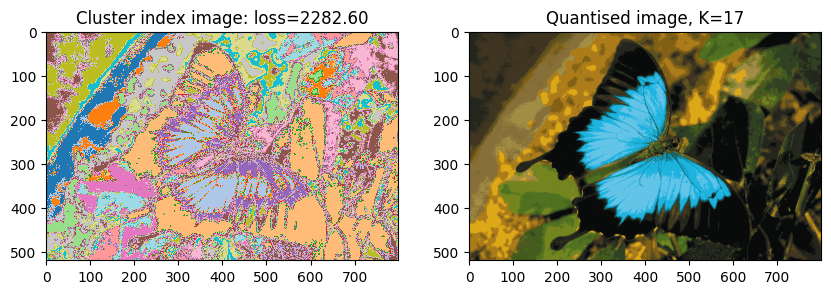

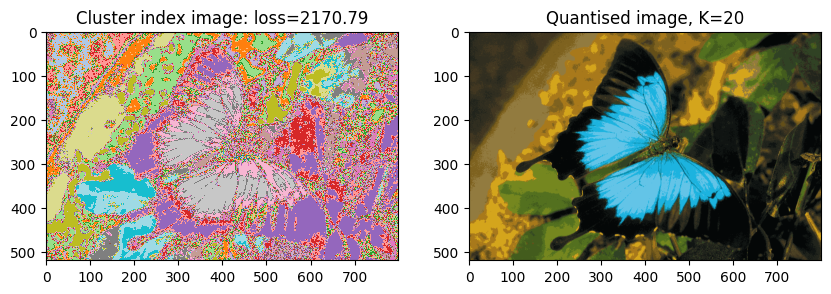

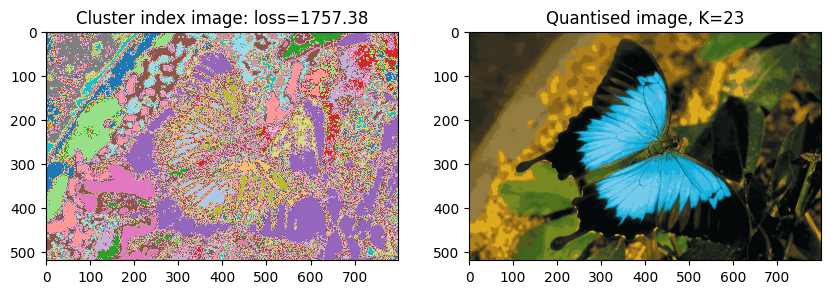

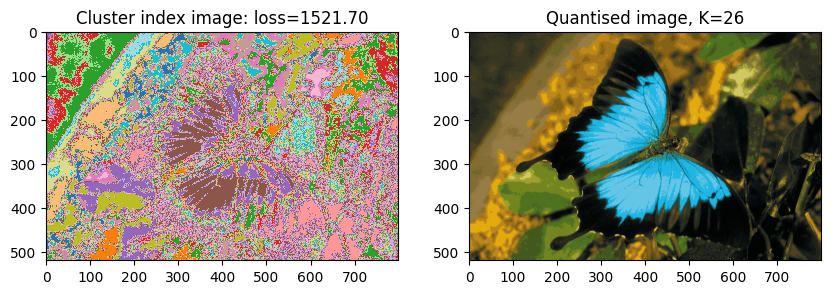

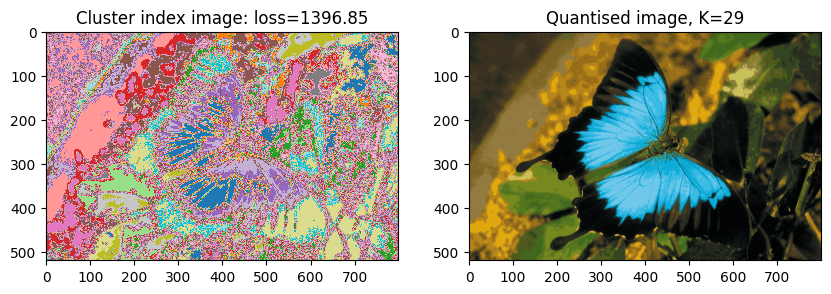

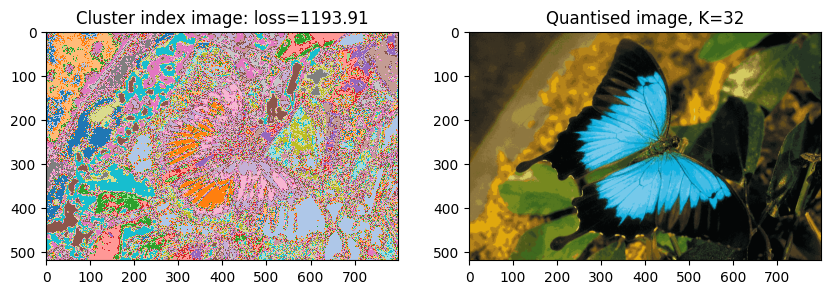

In [25]:
# Select an appropriate value for K and use visualisations to show how you did this.
# Testing different values of K: we will keep the number of iterations at 10
kvals = np.arange(2, 33, 3)
for k in kvals:
    # Compute loss and images
    loss, cluster_img, quantised_img = kmeans(im, iters=10, K=k, plot=False)
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(cluster_img, cmap='tab20')
    plt.title(f'Cluster index image: loss={loss:.2f}')
    plt.subplot(1, 2, 2)
    plt.imshow(quantised_img)
    plt.title(f'Quantised image, K={k}')

#### Improvements in image quality with increasing values of K:
- The quality with only 2 clusters is poor. By around 6 clusters, it resembles the original image. 
- At around K=6:K=17, the most improvements are made.
- The optimal value would be K=14 for this image
#### Iters = 10, K=14

### Task 2: Modify K-means to cluster based on colour similarity and pixel location and extract superpixels

1. Modify the k_means function above to segment based on colour and pixel location, so that you extract superpixels.

2. Test your implementation by clustering the image into 50 superpixels.

3. Select an appropriate pixel coordinate scaling factor so that you trade-off incorporating colour information into the clustering, while ensuring superpixel continuity (all pixels in a superpixel must remain connected).

In [26]:
# Use your kmeans function to cluster based on colour and location

def kmeans(im, iters=10, K=3, coordscaler=0.5, plot=False):
    # Kmeans is stochastic, so we will fix the seed of the random number generator to ensure each iteration starts with the same centroid initialisation
    seed = 42
    np.random.seed(seed)
    h, w, c = im.shape
    # Step 1: Modify our Nx3 pixel array into an Nx5 array with the pixel location
    xcords, ycords = np.meshgrid(np.arange(w), np.arange(h))
    xcords = xcords.flatten()
    ycords = ycords.flatten()

    # TODO: Assign a weight to the spacial coordinates if colour is more important
    coords = np.stack((xcords*coordscaler, ycords*coordscaler), axis=1)
    # Combine colours and locations:
    colours = im.reshape(-1, 3).astype(np.float64)
    pixels = np.hstack((coords, colours))
    # Create some random labels to assign to each pixel
    pix_labels = np.random.randint(0, K, im.shape[0]*im.shape[1])
    centroids = np.zeros((K, 5))
    for k in range(K):
        cluster_points = pixels[pix_labels == k]
        if len(cluster_points) == 0:
            centroids[k] = pixels[np.random.randint(0, N)]
        else:
            centroids[k] = cluster_points.mean(axis=0)
    for j in range(1,iters+1):
        # Assign pixels to clusters
        # i.e. assign each pixel to the cluster with the closest centroid
        dists = np.linalg.norm(pixels[:, None, :] - centroids[None, :, :], axis=2)
        cluster_indices = np.argmin(dists, axis=1)
        # Update centroid locations using new cluster assignments
        for k in range(K):
            cluster_pixels = pixels[cluster_indices == k]
            # I later ran into runtime errors when the cluster was empty, so I added this check
            if len(cluster_pixels)==0:
                centroids[k] = pixels[np.random.randint(0, pixels.shape[0])]
            else:
                centroids[k] = cluster_pixels.mean(axis=0)
            
        # Store the current loss
        # Loss = SSD to the centroids
        loss = np.sum((pixels - centroids[cluster_indices]) ** 2)

        
        # Convert cluster indices to an image
        cluster_idx_image = cluster_indices.reshape(h, w)
    
        # Create a quantised image using the clustering
        # For this step, we only want the colour part of the pixel
        quantised_pixels = centroids[cluster_indices][:, 2:]
        quantised_image = quantised_pixels.reshape(h, w, c)

        
        # You may want to visualise the current progress of kmeans for debugging purposes
        if plot:
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.title(f'Cluster index image, iteration {j}')
            plt.imshow(cluster_idx_image, cmap='tab20')
            plt.subplot(1,2,2)
            plt.imshow(quantised_image)
            plt.title(f'Quantised image, iteration {j}')
            plt.show()
        

    return loss, cluster_idx_image, quantised_image 


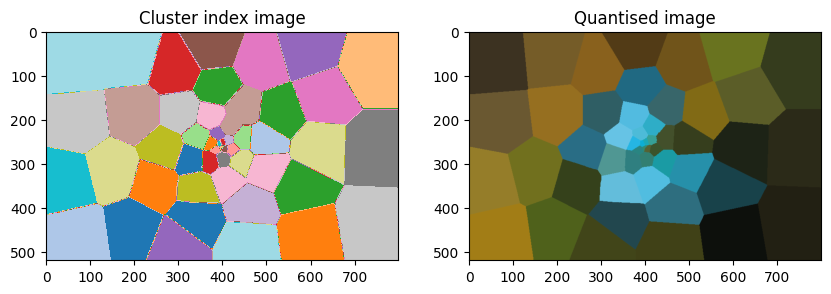

In [27]:
# Testing the function by creating 50 superpixels:
loss, cluster_img, quantised_image = kmeans(im, iters=10, K=50, coordscaler=0.1, plot=False)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cluster_img, cmap='tab20')
plt.title(f'Cluster index image')
plt.subplot(1, 2, 2)
plt.imshow(quantised_image)
plt.title(f'Quantised image')
plt.show()

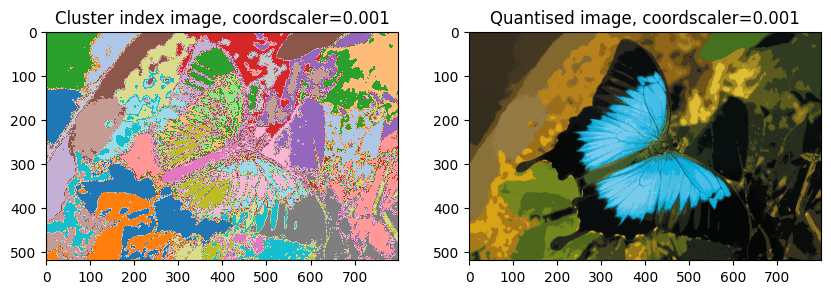

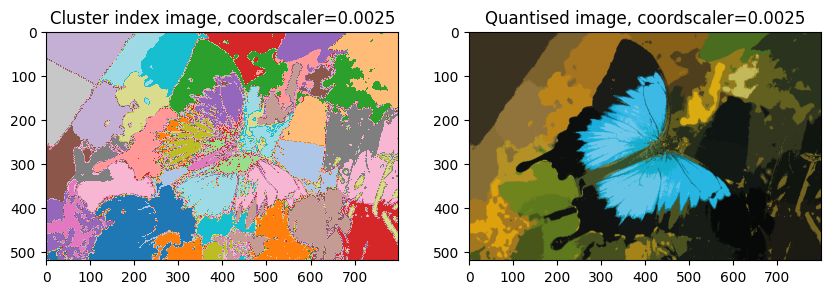

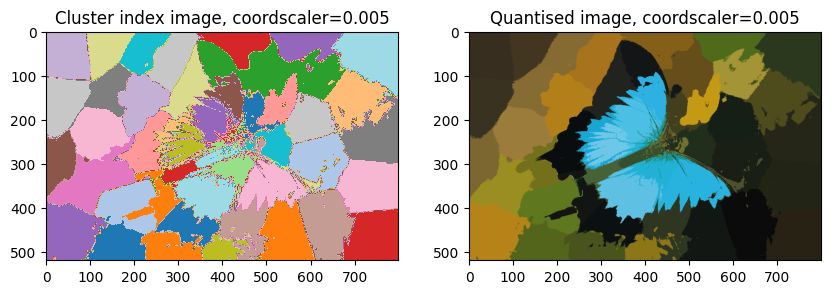

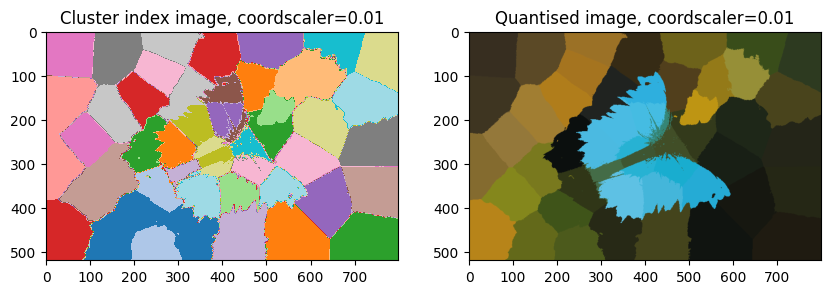

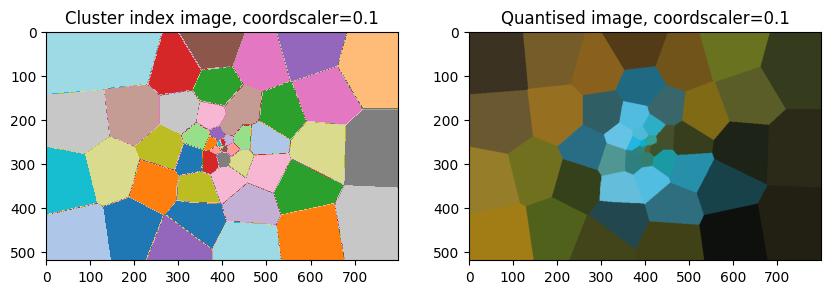

In [37]:
# Visualise your superpixel clustering for different scaling parameters 
scalers = [0.001, 0.0025, 0.005, 0.01, 0.1]
for s in scalers:
    loss, cluster_img, quantised_img = kmeans(im, iters=10, K=50, coordscaler=s, plot=False)
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(cluster_img, cmap='tab20')
    plt.title(f'Cluster index image, coordscaler={s}')
    plt.subplot(1, 2, 2)
    plt.imshow(quantised_img)
    plt.title(f'Quantised image, coordscaler={s}')
    plt.show()


## Task 3: Region proposal

Segment your image into 10 superpixels. Then find the locations of the top left pixel and bottom right pixel in a superpixel, and use this information and the cv2.rectangle function to draw rectangles (regions) on the original image for each superpixel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


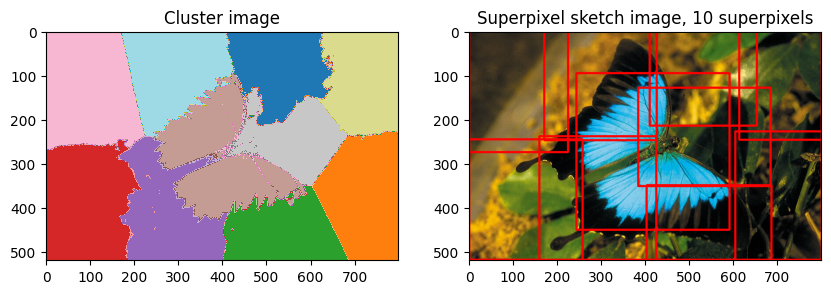

In [42]:
# Visualise your regions on the original image
# Segment the image into 10 superpixels:
K=10
loss, cluster_img, quantised_image = kmeans(im, iters=10, K=K, coordscaler=0.005, plot=False)
# Find the top left and bottom right corners of each superpixel
corners = []
for k in range(K):
    #Extract the pixels in the image where K=k (The superpixel)
    xi, yi, = np.where(cluster_img == k)
    #Then find the tl and br corners
    tl = (xi.min(), yi.min())
    br = (xi.max(), yi.max())
    corners.append((tl, br))
# Draw each rectangle using the corners
sketch_im = im.copy()

for tl, br in corners:
    cv2.rectangle(sketch_im, tl[::-1], br[::-1], (255, 0, 0), 3)
#Show result
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cluster_img, cmap='tab20')
plt.title('Cluster image')
plt.subplot(1, 2, 2)
plt.imshow(sketch_im)
plt.title(f'Superpixel sketch image, {K} superpixels')
plt.show()
    

## Task 4: Discussion

Write a brief report (max 600 words) discussing explaining your implementation
and results. Explain your reasoning by referencing the intermediate result figures
you generated.


--------------------
### Useability for feature detection
- K-means clustering which only accounts for colour in an image is useful for simplifying an image into patches, and is potentially useful for compressing images, however it has limited use for feature detection. By taking the RGB distance as well as the XY distance, the function becomes more versatile for feature detection.
#### Optimisation of the implementation
- Choosing the correct values for the number of iterations as well as the number of clusters required required trial and error.
    - Changing the number of iterations can quickly increase the time required to run the function. The quality of output images also has limited improvements past a certain point. In the case of this image, the optimum value was around 10 iterations. For most images of similar complexity, the program is likely to converge approximately as quickly.
    - The number of clusters for most images is unlikely to exceed 20. Images with more features in general are more likely to recquire more clusters for feature detection
    - Including spacial coordinates in the kmeans function drastically improves it's ability to create superpixels. However, the coordinates only need to have a small weighting in order to work correctly. If the coordinate scaling was considerably higher than the colour scaling, the superpixels would be pulled into a circular shape. Appropriate values tend to be 0.005-0.2.
### Results
- The final implementation is able to accurately identify the key features of the image, clearly emphasising the shape of the butterfly's wings as background noise is removed. However, some unique identifying features, such as the unique "swallowtail" wings of the Ulysses butterfly are omitted. A computer vision algorithm may be able to identify the image as a butterfly, but could struggle with distinguishing it from other species. This could be improved by decreasing the coordinate scaling factor, or increasing the value of K. This would improve the detectability of longer, thinner featured such as the thin body and swallowtail wings of the butterfly.
- The complexity of the program is proportional to the image size, K, and the number of iterations. For sections of the code which test high K values and numbers of iterations, the code takes around 1m to run completely.
